In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)
df = df[['Date', 'Close', 'EFFR']]
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']

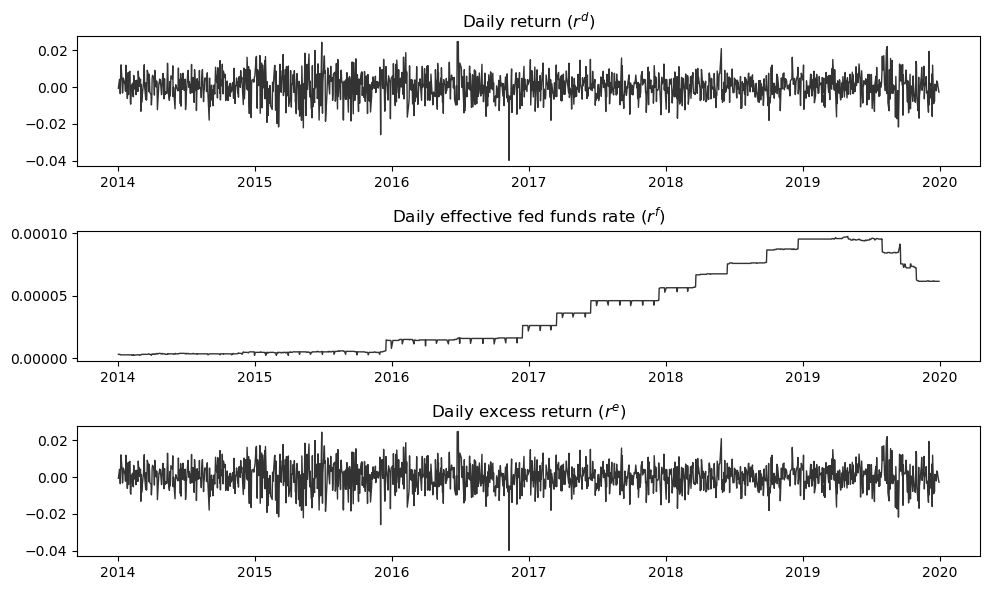

In [5]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1, alpha = 0.8)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1, alpha = 0.8)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1, alpha = 0.8)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: MACD Strategy

In [6]:
df['ema12'] = df['Close'].ewm(span = 12).mean()
df['ema26'] = df['Close'].ewm(span = 26).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span = 9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

train_size = int(len(df) * TRAINSIZE)
train_set = df[:train_size]
test_set = df[train_size:]

In [7]:
df.head()

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,ema12,ema26,macd,macd_signal,macd_hist
0,2014-01-02,30.055,0.08,0.000003,NaN,NaN,30.055000,30.055000,0.000000,0.000000,0.000000
1,2014-01-03,30.035,0.08,0.000003,-0.000665,-0.000669,30.044167,30.044615,-0.000449,-0.000249,-0.000199
2,2014-01-06,30.160,0.08,0.000003,0.004162,0.004159,30.089376,30.086072,0.003304,0.001207,0.002097
3,2014-01-07,30.260,0.07,0.000003,0.003316,0.003313,30.143236,30.134695,0.008541,0.003692,0.004849
4,2014-01-08,30.150,0.07,0.000003,-0.003635,-0.003638,30.145073,30.138244,0.006829,0.004625,0.002204


<BarContainer object of 1509 artists>

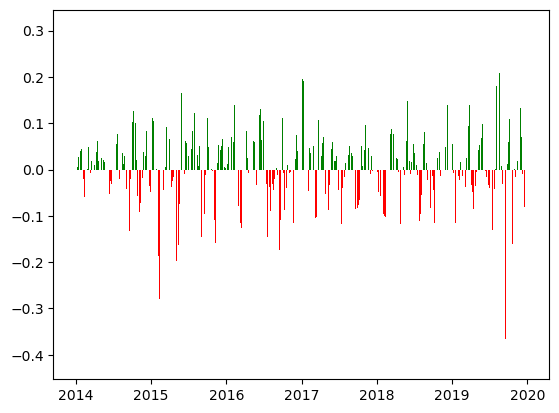

In [8]:
color = np.where(df['macd_hist'] >= 0, 'green', 'red')
plt.bar(df['Date'], df['macd_hist'], color = color)

In [9]:
# Trading signal
regime = [0]
macd_hist = np.array(df['macd_hist'])
for i in range(1, len(macd_hist)):
    if macd_hist[i] >= 0 and macd_hist[i-1] < 0:
        regime.append(1)
    elif macd_hist[i] <= 0 and macd_hist[i-1] > 0:
        regime.append(-1)
    else:
        regime.append(0)
        
regime_train = regime[:train_size]
regime_test = regime[train_size:]

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


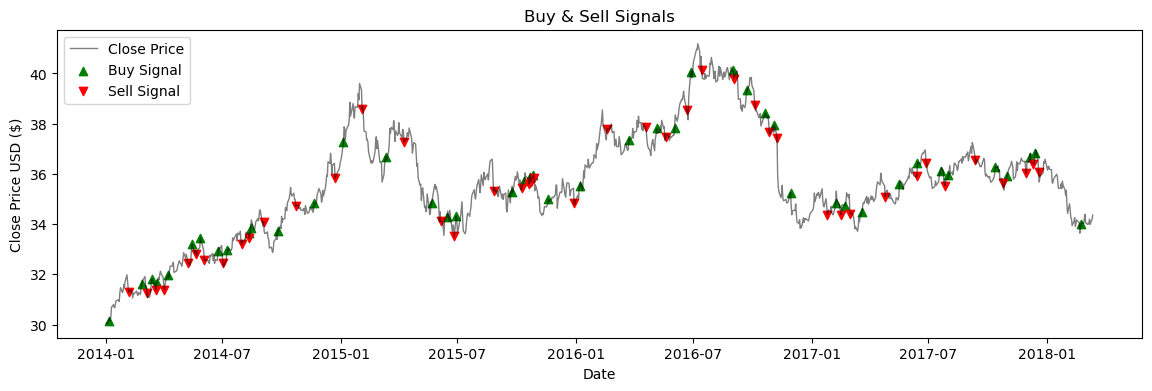

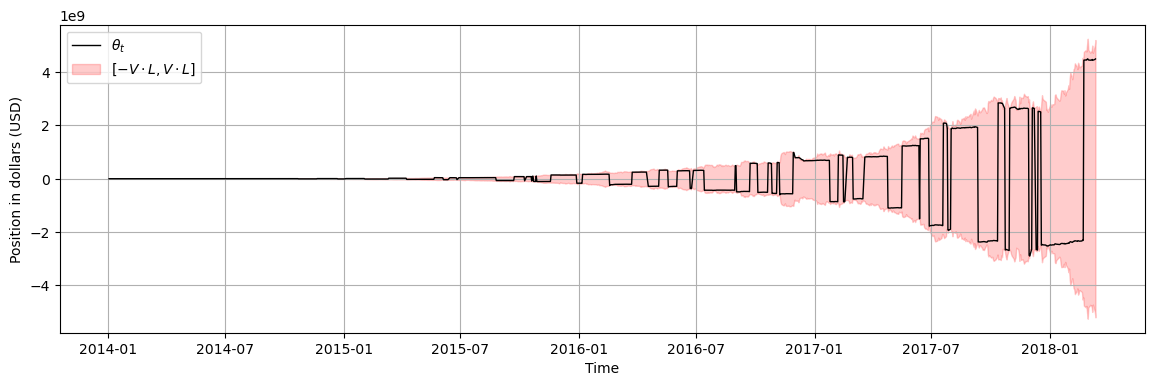

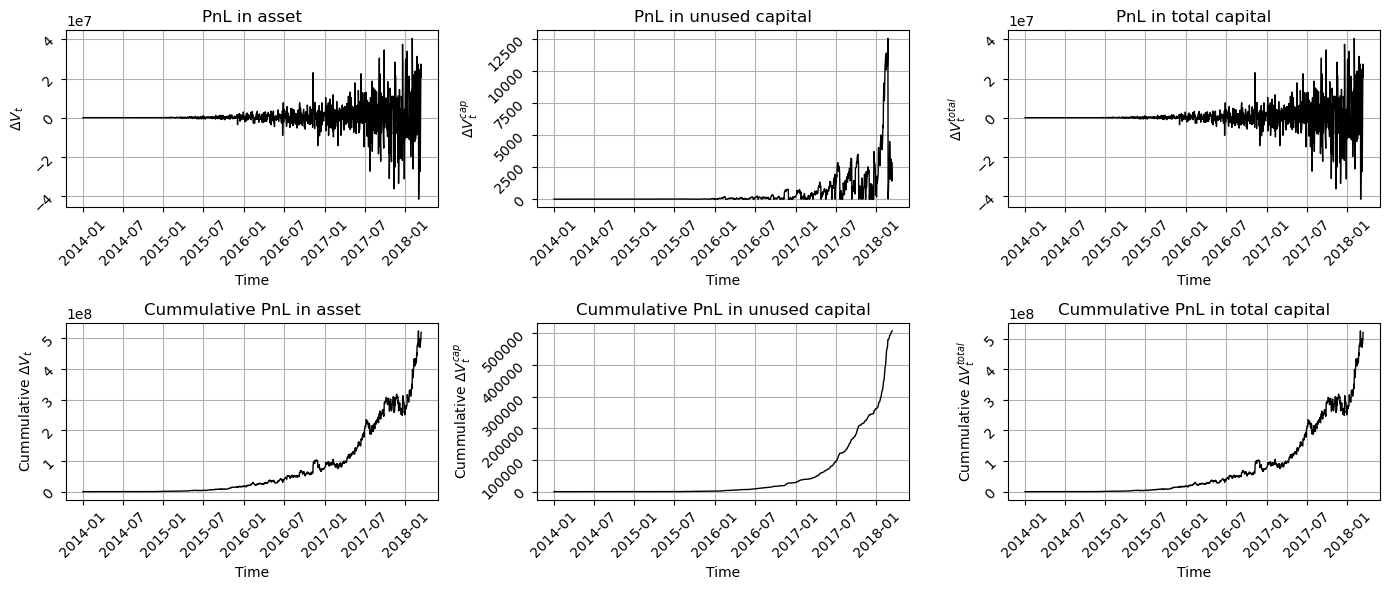

In [10]:
result_train = compute_position_value(df = train_set, 
                           signal = regime_train, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = train_set, 
              result_dict = result_train, 
              signal = regime_train, 
              leverage = LEVERAGE)

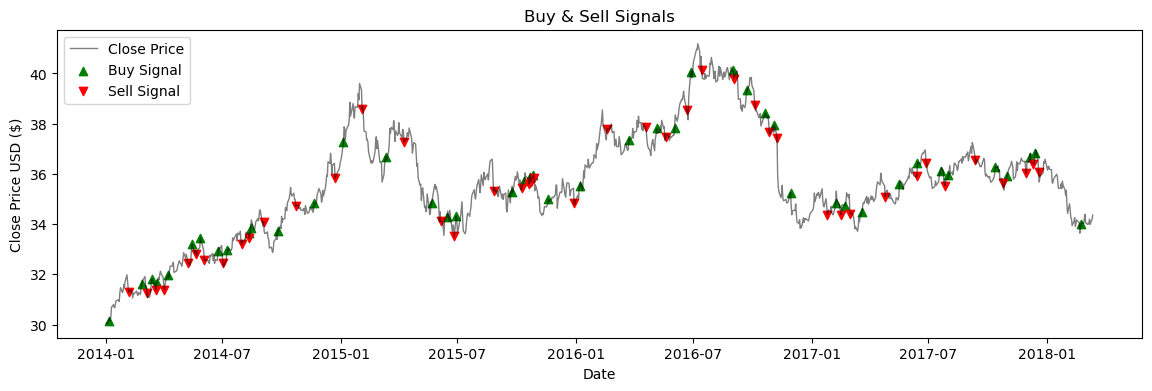

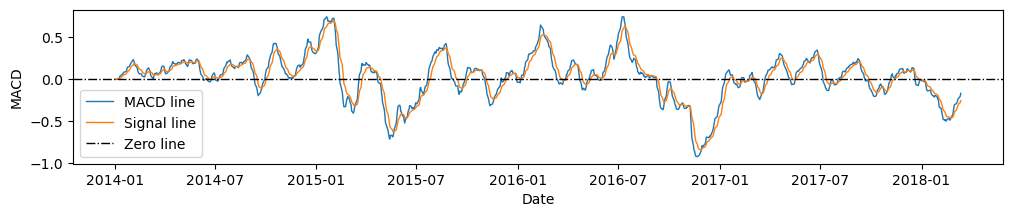

In [17]:

plot_signals(strategy_data=train_set, signal = regime_train)
fig, ax = plt.subplots(1, 1, figsize = (12, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MACD')

buy_macd = np.array(train_set['macd'])[np.where(regime_train == 1)]
buy_macd_time = np.array(train_set['Date'])[np.where(regime_train == 1)]
sell_macd = np.array(train_set['macd'])[np.where(regime_train == -1)]
sell_macd_time = np.array(train_set['Date'])[np.where(regime_train == -1)]

ax.plot(train_set['Date'], train_set['macd'], lw = 1, label = 'MACD line')
ax.plot(train_set['Date'], train_set['macd_signal'], lw = 1, label = 'Signal line')
ax.axhline(y = 0, color = 'black', lw = 1, ls = '-.', label = 'Zero line')
# plt.scatter(buy_macd_time, buy_macd, label='Buy Signal', marker='^', alpha=1, color='green')
# plt.scatter(sell_macd_time, sell_macd, label='Sell Signal', marker='v', alpha=1, color='red')

color = np.where(train_set['macd_hist'] >= 0, 'green', 'red')

# plt.plot(df['Date'], df['macd'], label = 'MACD')
# plt.plot(df['Date'], df['macd_signal'], label = 'Signal')
# ax.bar(train_set['Date'], train_set['macd_hist'], color = color)
ax.legend(loc='lower left')


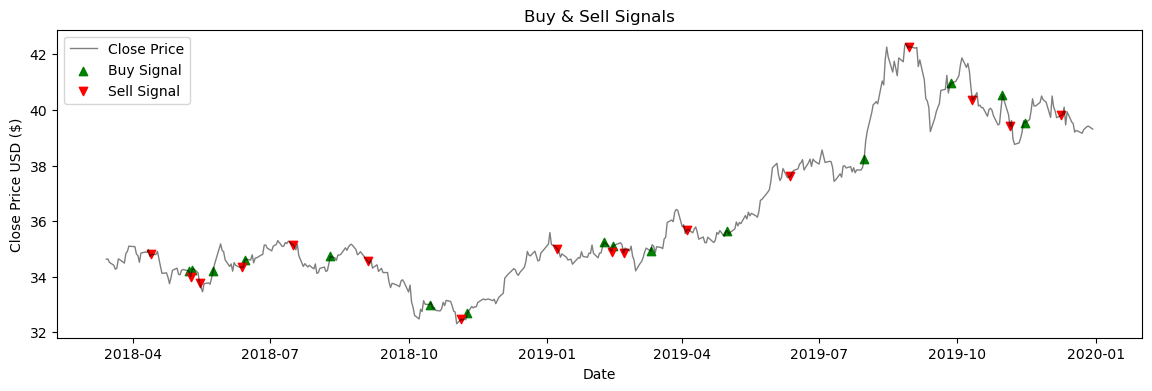

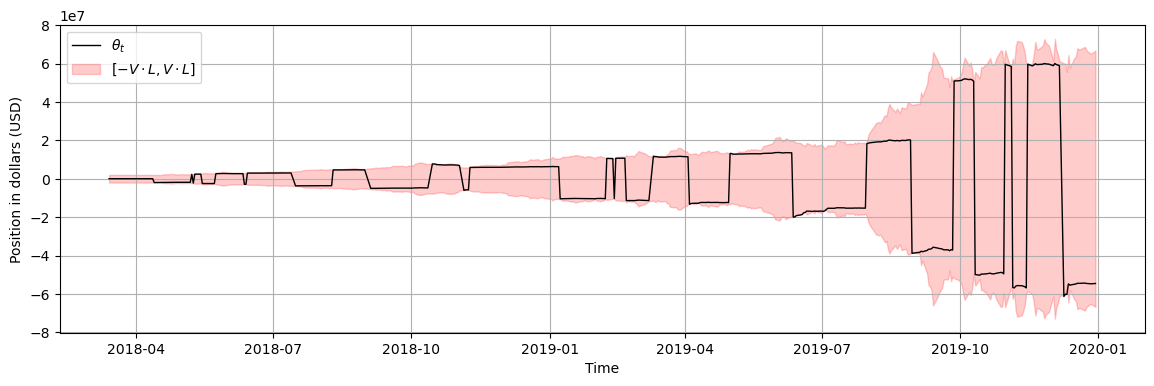

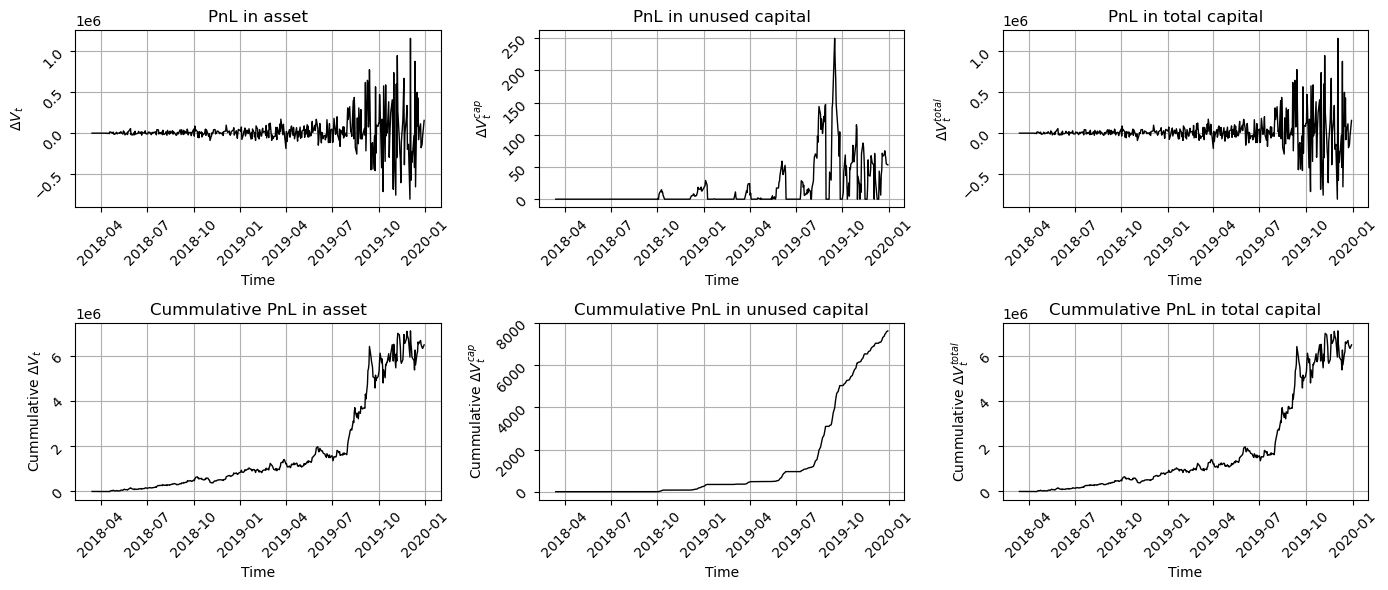

In [12]:
# Testing set performance
result_test = compute_position_value(df = test_set, 
                           signal = regime_test, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = test_set, 
              result_dict = result_test, 
              signal = regime_test, 
              leverage = LEVERAGE)

In [13]:
compute_sharpe_ratio(result_test['dV'])
compute_sortino_ratio(result_test['dV'])
compute_drawdown(result_test['Vtot'], max_drawdown = True)
compute_drawdown(result_test['Vtot'], max_drawdown= False)
compute_calmar_ratio(result_test['dV'], result_test['V'])

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/performance_indicator.py:75: RuntimeWarning: divide by zero encountered in divide
  drawdown = (running_max - portfolio_value) / running_max
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/performance_indicator.py:75: RuntimeWarning: invalid value encountered in divide
  drawdown = (running_max - portfolio_value) / running_max


45295.78110496198

In [14]:
print(f"Sharpe ratio: {compute_sharpe_ratio(result_test['dV'])}")
print(f"Sortino ratio: {compute_sortino_ratio(result_test['dV'])}")
print(f"Max drawdown: {compute_drawdown(result_test['Vtot'], max_drawdown = True)}")
print(f"Calmer ratio: {compute_calmar_ratio(result_test['dV'], result_test['Vtot'])}")


Sharpe ratio: 0.07522887428940667
Sortino ratio: 0.09599881696928672
Max drawdown: nan
Calmer ratio: nan


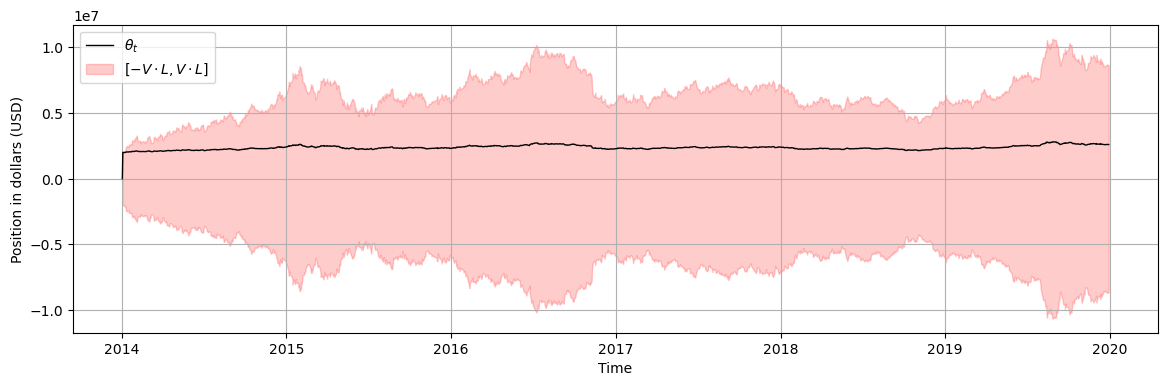

In [15]:
buy_and_hold_signal = np.zeros(len(df))
buy_and_hold_signal[1] = 1

result = compute_position_value(df = df, 
                           signal = buy_and_hold_signal, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)
plot_position(df['Date'], result['theta'], result['V'], leverage=LEVERAGE) 

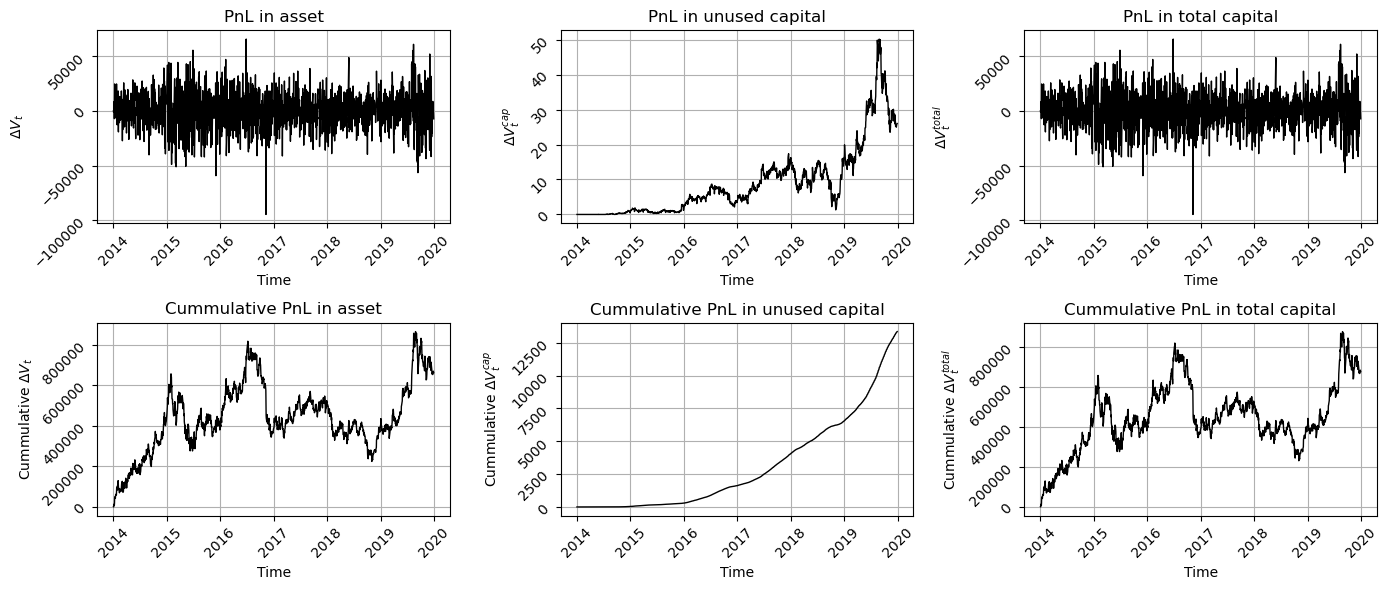

In [16]:
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])